In [1]:
import os
import cv2
import time
import torch
import random
import numpy as np
from datetime import datetime
import albumentations as augs
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from train import *
from models import *
from datasets import *
from evaluation import *


print('Ready')

Ready


In [2]:
# Data augmentation transforms
geometric_transform=augs.ShiftScaleRotate(scale_limit=0.2, rotate_limit=50, p=0.5,
                                          border_mode=cv2.BORDER_CONSTANT)
content_transform=augs.Compose([augs.Blur(p=0.5), augs.ColorJitter(0.3, 0.3, 0.3, 0,3, p=1.0),
                                augs.ImageCompression(quality_lower=30, p=0.5),
                                augs.CoarseDropout(min_holes=1, max_holes=8,
                                                   min_width=0.03125, min_height=0.03125,
                                                   max_width=0.125, max_height=0.125, p=0.5)])
print('Data augmentation transforms created.')

Data augmentation transforms created.


In [3]:
# Prepare datasets
trainset = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'train'),
                           geometric_transform=geometric_transform, content_transform=content_transform,
                           random_flip=True)
trainset_indoor = LandmarkDataset('./data/300w.tsv', [('frgc', ''), ('xm2vts', '')],
                                  geometric_transform=geometric_transform, content_transform=content_transform,
                                  random_flip=True)
trainset_outdoor = LandmarkDataset('./data/300w.tsv', [('afw', ''), ('helen', 'trainset'), ('lfpw', 'trainset')],
                                   geometric_transform=geometric_transform, content_transform=content_transform,
                                   random_flip=True)
print(f"300W training set contains has {len(trainset)} examples.")
print(f"300W indoor training set contains has {len(trainset_indoor)} examples.")
print(f"300W outdoor training set contains has {len(trainset_outdoor)} examples.")
print('')

trainset_lp = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'train'),
                              geometric_transform=geometric_transform, content_transform=content_transform,
                              random_flip=True)
trainset_lp_indoor = LandmarkDataset('./data/300w_lp.tsv', [('frgc', ''), ('xm2vts', '')],
                                     geometric_transform=geometric_transform, content_transform=content_transform,
                                     random_flip=True)
trainset_lp_outdoor = LandmarkDataset('./data/300w_lp.tsv', [('afw', ''), ('helen', 'trainset'), ('lfpw', 'trainset')],
                                      geometric_transform=geometric_transform, content_transform=content_transform,
                                      random_flip=True)
print(f"300W-LP training set contains has {len(trainset_lp)} examples.")
print(f"300W-LP indoor training set contains has {len(trainset_lp_indoor)} examples.")
print(f"300W-LP outdoor training set contains has {len(trainset_lp_outdoor)} examples.")
print('')

valset = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'val'))
valset_lp = LandmarkDataset('./data/300w_lp.tsv', LandmarkDataset.get_partitions('300w_lp', 'val'))
print(f"300W validations set contains has {len(valset)} examples.")
print(f"300W-LP validations set contains has {len(valset_lp)} examples.")
print('')

testset = LandmarkDataset('./data/300w.tsv', LandmarkDataset.get_partitions('300w', 'test'))
testset_indoor = LandmarkDataset('./data/300w.tsv', [('300W', '01_Indoor')])
testset_outdoor = LandmarkDataset('./data/300w.tsv', [('300W', '02_Outdoor')])
print(f"300W test set contains has {len(testset)} examples.")
print(f"300W indoor test set contains has {len(testset_indoor)} examples.")
print(f"300W outdoor test set contains has {len(testset_outdoor)} examples.")

300W training set contains has 10458 examples.
300W indoor training set contains has 7310 examples.
300W outdoor training set contains has 3148 examples.

300W-LP training set contains has 180689 examples.
300W-LP indoor training set contains has 130364 examples.
300W-LP outdoor training set contains has 50325 examples.

300W validations set contains has 689 examples.
300W-LP validations set contains has 10758 examples.

300W test set contains has 600 examples.
300W indoor test set contains has 300 examples.
300W outdoor test set contains has 300 examples.


In [4]:
def eval_on_300w(model, threshold=0.7):
    # Evaluate the model on the test set
    with torch.no_grad(), tqdm(desc='Test batch') as pbar:
        test_results = run_model(model, testset_loader, pbar=pbar)
    torch.cuda.empty_cache()
    with torch.no_grad(), tqdm(desc='Test batch (indoor)') as pbar:
        test_results_indoor = run_model(model, testset_indoor_loader, pbar=pbar)
    torch.cuda.empty_cache()
    with torch.no_grad(), tqdm(desc='Test batch (outdoor)') as pbar:
        test_results_outdoor = run_model(model, testset_outdoor_loader, pbar=pbar)
    torch.cuda.empty_cache()
    
    # Compute AUC
    threshold = 0.07
    test_lmk_errors = compute_landmark_errors(
        test_results['predicted_landmarks'].mean(axis=1), test_results['landmarks'])
    test_lmk_bbox_sizes = get_bbox_sizes(test_results['landmark_bbox_corners'])[0]
    auc, errs, ticks = compute_auc(
        test_lmk_errors, threshold, test_lmk_bbox_sizes)

    test_lmk_errors_indoor = compute_landmark_errors(
        test_results_indoor['predicted_landmarks'].mean(axis=1), test_results_indoor['landmarks'])
    test_lmk_bbox_sizes_indoor = get_bbox_sizes(test_results_indoor['landmark_bbox_corners'])[0]
    auc_indoor, errs_indoor, ticks_indoor = compute_auc(
        test_lmk_errors_indoor, threshold, test_lmk_bbox_sizes_indoor)

    test_lmk_errors_outdoor = compute_landmark_errors(
        test_results_outdoor['predicted_landmarks'].mean(axis=1), test_results_outdoor['landmarks'])
    test_lmk_bbox_sizes_outdoor = get_bbox_sizes(test_results_outdoor['landmark_bbox_corners'])[0]
    auc_outdoor, errs_outdoor, ticks_outdoor = compute_auc(
        test_lmk_errors_outdoor, threshold, test_lmk_bbox_sizes_outdoor)

    # Show results
    fig = plt.figure(figsize=(8, 6))
    plt.plot(errs, ticks, label=f"Full testset, AUC@{threshold}={auc:.03f}")
    plt.plot(errs_indoor, ticks_indoor, label=f"Indoor subset, AUC@{threshold}={auc_indoor:.03f}")
    plt.plot(errs_outdoor, ticks_outdoor, label=f"Outdoor subset, AUC@{threshold}={auc_outdoor:.03f}")
    plt.title('CED on 300W (normalised by landmark bounding box size)')
    plt.xlim(0, threshold)
    plt.ylim(0, 1)
    plt.xlabel('Normalised distance error')
    plt.ylabel('Proportion')
    plt.legend()
    plt.grid('both')


testset_loader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
testset_indoor_loader = DataLoader(testset_indoor, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
testset_outdoor_loader = DataLoader(testset_outdoor, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('300W test data loaders created.')

300W test data loaders created.


## Experiment 0.1: Test the pretrained 4-hourglass model on 300W

Test batch: 0it [00:00, ?it/s]

Test batch (indoor): 0it [00:00, ?it/s]

Test batch (outdoor): 0it [00:00, ?it/s]

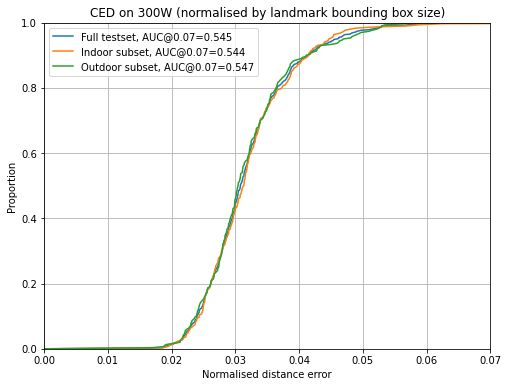

In [5]:
fan = FAN(FAN.create_config(num_modules=4, use_avg_pool=True)).cuda()
fan.load_state_dict(torch.load('./pretrained/2dfan4.pth', map_location='cuda:0'))
eval_on_300w(fan)
del fan
torch.cuda.empty_cache()

## Experiment 0.2: Test the pretrained 2-hourglass model on 300W

Test batch: 0it [00:00, ?it/s]

Test batch (indoor): 0it [00:00, ?it/s]

Test batch (outdoor): 0it [00:00, ?it/s]

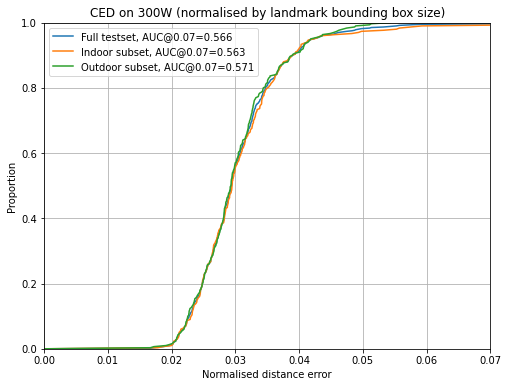

In [6]:
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).cuda()
fan.load_state_dict(torch.load('./pretrained/2dfan2.pth', map_location='cuda:0'))
eval_on_300w(fan)
del fan
torch.cuda.empty_cache()

## Experiment 1.1: Train FAN2 on 300W for 10 epochs
This is just to make sure that everything works.

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=8, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_01_01_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 10, './logs', './checkpoints',
        f"exp_01_01_fan2_300w_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=2, save_top_k=5,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
del lr_scheduler
del optimiser
del fan
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_01_01_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_01_01_fan2_300w_2021-10-25_00-45-06.388_utc.ckpt


Best weights loaded using snapshot saved at epoch #9.502


Test batch: 0it [00:00, ?it/s]

Test batch (indoor): 0it [00:00, ?it/s]

Test batch (outdoor): 0it [00:00, ?it/s]

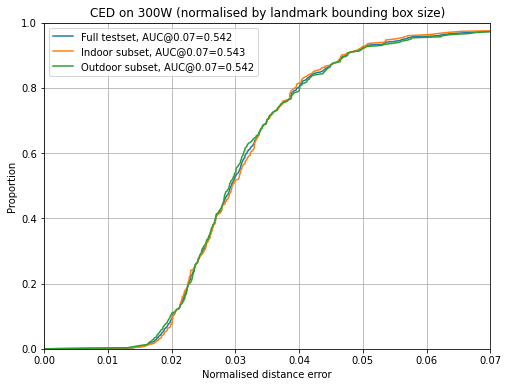

In [6]:
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
ckpt = torch.load(exp_01_01_ckpt_path, map_location='cuda:0')
fan.load_state_dict(ckpt['best_snapshots'][0]['model_state_dict'])
print(f"Best weights loaded using snapshot saved at epoch #{ckpt['best_snapshots'][0]['epoch']:.3f}")
del ckpt
torch.cuda.empty_cache()

eval_on_300w(fan)
del fan
torch.cuda.empty_cache()

## Experiment 1.2: Train FAN2 on 300W-LP for 10 epochs
This is a preliminary test, just to see what performance we may expect from 300W-LP.

In [5]:
# Create data loaders
trainset_loader = DataLoader(trainset_lp, batch_size=32, shuffle=True, num_workers=32, pin_memory=True)
valset_loader = DataLoader(valset_lp, batch_size=16, shuffle=False, num_workers=32, pin_memory=True)
print('Data loaders created.')

# Create the model
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False))
fan = torch.nn.DataParallel(fan).cuda()
print('Network initialised.')

# Create the optimiser
optimiser = torch.optim.RMSprop(fan.parameters(), lr=2.5e-4, momentum=0.9, weight_decay=0.0)
print('Optimiser created.')

# Create the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.7)
print('LR scheduler created.')

# Train the network
torch.cuda.empty_cache()
with tqdm(desc='Epoch') as pbar1, tqdm(desc='Train batch') as pbar2, tqdm(desc='Validation batch') as pbar3:
    exp_01_02_ckpt_path = train_model(
        fan, optimiser, trainset_loader, valset_loader, 10, './logs', './checkpoints',
        f"exp_01_02_fan2_300w_lp_{datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S.%f')[:-3]}_utc",
        lr_scheduler=lr_scheduler, val_per_epoch=10, save_top_k=10,
        htm_mse_loss_weight=1.0, lmk_dist_loss_weight=0.01, rank_by='val_weighted_macc',
        train_weight_norm=trainset_loader.dataset.weight_norm,
        pbar_epochs=pbar1, pbar_train_batches=pbar2, pbar_val_batches=pbar3)
torch.cuda.empty_cache()
print(f"Training finished, checkpoint saved to: {exp_01_02_ckpt_path}")

Data loaders created.


/home/hhj/anaconda3/envs/py37misc/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


Network initialised.
Optimiser created.
LR scheduler created.


Epoch: 0it [00:00, ?it/s]

Train batch: 0it [00:00, ?it/s]

Validation batch: 0it [00:00, ?it/s]

Training finished, checkpoint saved to: ./checkpoints/exp_01_02_fan2_300w_lp_2021-10-25_01-46-21.133_utc.ckpt


Best weights loaded using snapshot saved at epoch #9.200


Test batch: 0it [00:00, ?it/s]

Test batch (indoor): 0it [00:00, ?it/s]

Test batch (outdoor): 0it [00:00, ?it/s]

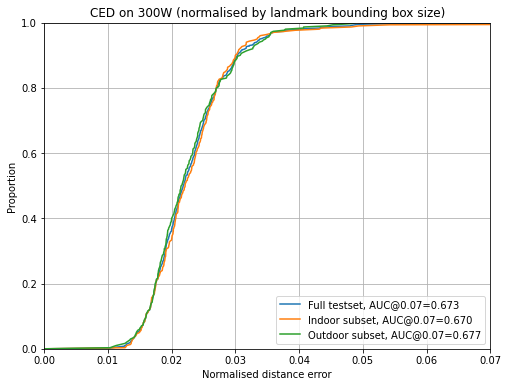

In [6]:
fan = FAN(FAN.create_config(num_modules=2, use_avg_pool=False)).to('cuda:0')
ckpt = torch.load(exp_01_02_ckpt_path, map_location='cuda:0')
fan.load_state_dict(ckpt['best_snapshots'][0]['model_state_dict'])
print(f"Best weights loaded using snapshot saved at epoch #{ckpt['best_snapshots'][0]['epoch']:.3f}")
del ckpt
torch.cuda.empty_cache()

eval_on_300w(fan)
del fan
torch.cuda.empty_cache()